# Decision curve analysis or why interpretation of medical statistical models should be based on their potential medical benefit
*Where we explore why decision curve analysis is very powerful for medical models*

# Introduction
One of the goals of statistical models is often that they perform their job just as well, or even better then medical professionals. But how you define 'performance' in this context is crucial as choosing the wrong metric will not lead to a meaningful comparison of model-vs-human. For example, how often the model or professional makes the correct decision, i.e. accuracy, feels like a natural choice. However, in medical datasets the number of sick people is often much smaller than the number of healthy people. If, for exanple, 99 percent of patients is healthy, a very simple statistical model that states everyone is healthy has 99 eprcent accuracy. If missing a sick patient means they die, this 99 percent accuracy is not worth much. 

So choosinig the correct metric to interpret statistical models is not easy. The goal of this article is to explain a number of common metrics and their repsective upsides and downsides. We will buildup to a final metric, net_benefit (TODO: cite papers), which in our view provides a straightforward manner to assess statistical models from a medical perspective. First, we introduce the 

# Our case study
To explore the various metrics we use the following case study (TODO: cite source) that contains patients for whom there are suspicions that they have prostate cancer. The definitive way to determine prostate cancer is to collect a tissue sample via a biopsy. However, the biopsy itself is not without risks so we are faced with a number of alternatives:

- Biopsy all patients, ensuring we do not miss any prostate cancer, at the cost of many unnecessary biopsies
- Biopsy no one, ensuring no unecessary biopsies, at the cost of missing some patients with prostate cancer
- A statistical model that determines whom of the patients we should biopsy or not based on patient characteristics. 

Intuitively, the options to biopsy no one or everyone might seem ridiculous, but you will see that things are not that easy in the next few chapters. 

First we introduce the model. It uses the age of the patient (`age`), a genetic marker (`marker`) and wether or not there is a family history of cancer (`famhistory`) to predict if the patient has cancer or not (`cancer`). If the model judges it likely that the patient has cancer, we perform a biopsy. 

In [13]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from helper_functions import *

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')

complex_model = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial()).fit()
print(complex_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      746
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.89
Date:                Wed, 27 Mar 2024   Deviance:                       427.79
Time:                        11:58:47   Pearson chi2:                     743.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2130
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.0703      2.211     -9.984      0.0

A good way to interpret these coefficients is to transform them to odds. Remembering that logistic regression is based on the logit transform, we can take the exponent of the model parameters:

In [14]:
np.exp(complex_model.params)

Intercept     2.600116e-10
age           1.325770e+00
marker        2.660012e+00
famhistory    2.375435e+00
dtype: float64

This should be interpreted as:

- `intercept` For a patient with the hypotheical age 0, zero score on the marker and no family history of cancer the odds are almost zero that a patient has cancer.
- `age` for each year the patient is older, the odds of cancer become 1.3 times bigger. 
- `marker` for each increase of 1 for the marker, the odds of cancer become 2.7 times bigger.
- `famhistory` a family history of cancer increases the likelihood of cancer 2.4 times. 

Note that the `P>|z|` values are well below 0.025, so this models seems to have predictive power and would be promising to base our biopsy/no-biopsy decision on. 

This is further confirmed if we draw a scatterplot including the decision boundary of probability threshold 0.5 and patients with a history of cancer in the family:

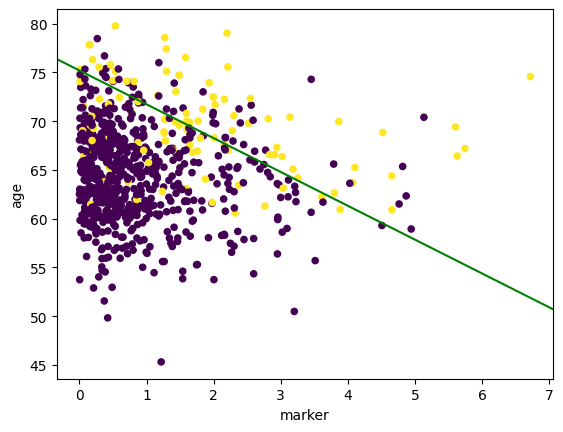

In [15]:
import matplotlib.pyplot as plt

p_thold = 0.5
logit_p = np.log(p_thold / (1 - p_thold))

marker_range = np.linspace(*df_cancer_dx['marker'].agg(['min', 'max']))
complex_model.params

ax = df_cancer_dx[['cancer', 'marker', 'age']].plot(kind='scatter', x='marker', y='age', c='cancer', colormap='viridis', colorbar=False)

c_intercept, c_age, c_marker, c_famhistory = complex_model.params
marker_range = df_cancer_dx['marker'].agg(['min', 'max'])

famhistory = 1
age_pred = (-c_intercept - c_marker * marker_range - c_famhistory * famhistory + logit_p) / c_age
ax.axline((marker_range[0], age_pred[0]), (marker_range[1], age_pred[1]), color='green', label='famhistory')   

where we can see that patients in the 'high-marker/high-age' quadrant of the data are much more likely to have cancer. 

# The building blocks of model evaluation
The key in evaluating any model is to look at how often it makes the correct decision. Note that all of the points under the line are predicted to not have cancer and thus not need a biopsy. There are definitely still yellow dots under the line, which means that the model is not perfect and makes a mistake. In the case the mistake is called a False Negative, falsely assuming a biopsy is not needed. The inverse of this error is a False Positive, we perform an unneeded biopsy on a patient. 

These False Positive and False Negative errors form the basis of the evalution metrics we will evaluate in this article. The model also correctly predicts that some people will or will not have cancer, these are the True Positives (correct cancer) and True Negatives (correct non-cancer). These four possible options (TP, TN, FP, TN) provide the basis for each of the metics we will explore. 

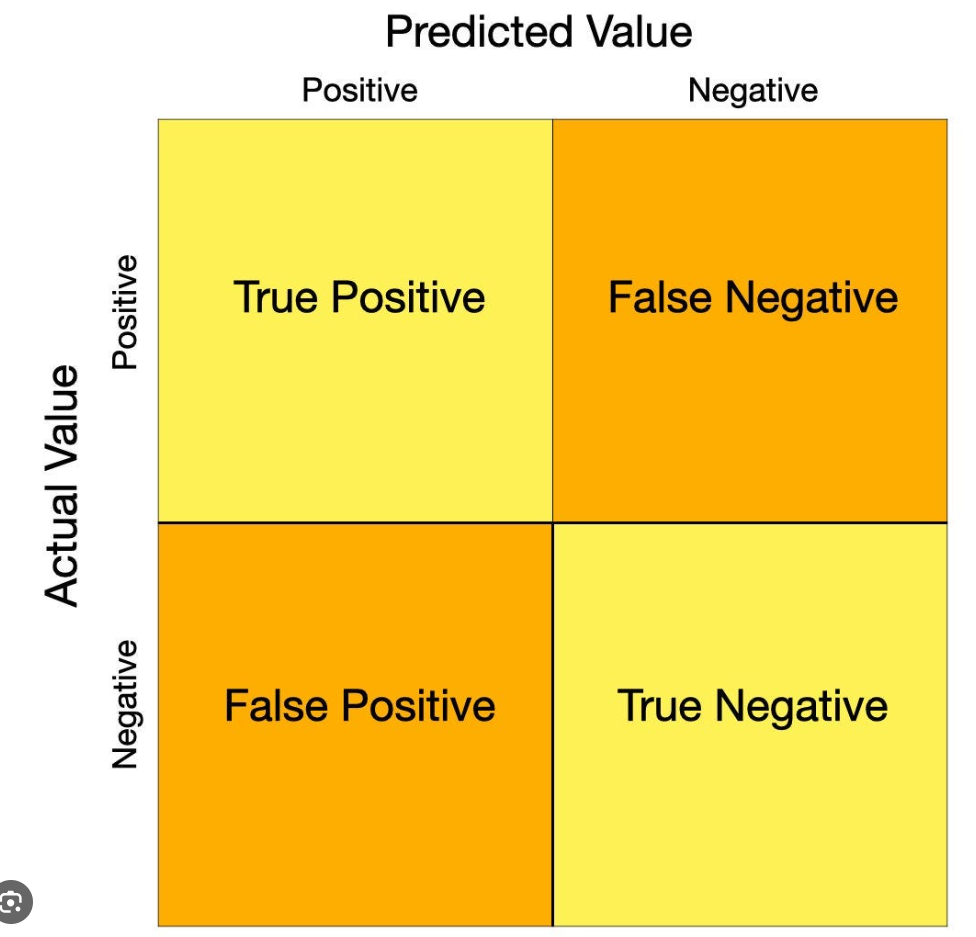

# The most basic metric: accuracy
For many machine learning models, accuracy is the most obvious performance metric to use. This is simply defined as the fraction of times the model makes the correct decision:

$$
ACC = \frac{TP + TN}{n_{total} + n_{non-cancer}}
$$

The accuracy of our model is:

In [16]:
from sklearn.metrics import accuracy_score
thold = 0.5

accuracy_score(complex_model.predict(df_cancer_dx[['age', 'marker', 'famhistory']]) >= thold, df_cancer_dx['cancer'])

0.8813333333333333

Note that we have to include a threshold here as the model prediction returns a probability of cancer. To get a concrete 0/1 decision from this we need to define from which threshold probability onwards we classify a patient as have cancer. 

For our two other treatment options (biopsy everyone, biopsy no one) we get the following accuracies:

In [17]:
# biopsy everyone
print(accuracy_score(np.ones(len(df_cancer_dx['cancer'])) >= thold, df_cancer_dx['cancer']))
#  biopsy no one
print(accuracy_score(np.zeros(len(df_cancer_dx['cancer'])) >= thold, df_cancer_dx['cancer']))

0.14
0.86


This is an unexpected result, our model seemed to have significant predictive power but the accuracy is only slightly higher then simply giving no one a biopsy. Intuitively this also does not make sense, performing no biopsies because we deem people to not be sick means quite a number of patients will die. 

Looking at the accuracies for `biopsy-everyone` and `biopsy-no-one` provides a hint as to what is going on: the accuracies are the exact fractions of cancer and non-cancer patients in the dataset. In addition, the number of healthy patients is much larger or in statistical terms: the dataset is unbalanced. This means that the extremely simple `biopsy-no-one` model can have a very high accuracy, which is not really meaningful beacuase of the unbalanced dataset. 

# A better metric: Area under curve (AUC)
So, we need a metric to assess medical models that can deal with the typically unbalanced datasets we find in medical applications. A trick that is often used is to not look at the fraction or rate of good decisions versus the entire ddeataset, but the fraction of good decisions *per category* (cancer/non-cancer). The two key ones are the True Positive Rate (TPR) and the False Positive Rate (FPR):

- TPR, what fraction of the time does the model predict cancer *when the patient actually has cancer* ($TPR = \frac{TP}{n_{cancer}}$) and thus the biopsy was correctly performed. This is also known as the *sensitivity* of the model. 
- FPR, what fraction of the time does the model predict cancer when the patient actually *does **not** have cancer* ($FPR = \frac{FP}{n_{non-cancer}}$), and the the biopsy was unecessary. This is also know as one minus the *sensitivity* of the model. 

Important in this context is that both the TPR and FPR depend on the decision threshold $\theta$, which determines above which probability of cancer a biopsy is ordered. Take the following illustration that shows the distribution of probabilities of cancer for all the patients, with a density line (kind of histogram) for both the cancer and non-cancer patients:

<Axes: title={'center': 'Density plot'}, ylabel='Density'>

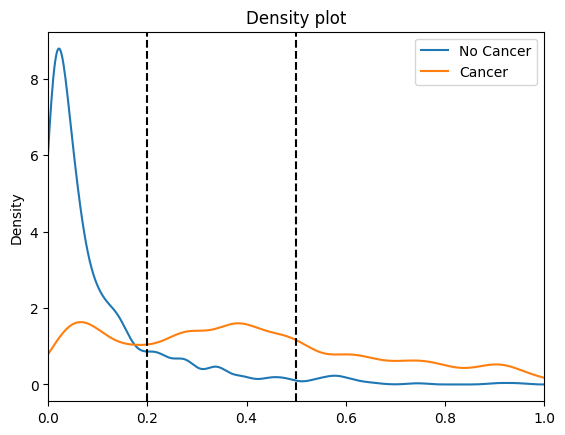

In [18]:
df_cancer_dx['complex_prob'] = complex_model.predict(df_cancer_dx)
df_cancer_dx['noone_prob'] = np.zeros(len(df_cancer_dx['cancer'])) 
df_cancer_dx['everyone_prob'] = np.ones(len(df_cancer_dx['cancer'])) 

prob_density_plot(df_cancer_dx, y='complex_prob', by='cancer')

Important to note here:

- Non-cancer patients overwhelmingly have a low predicted probability of cancer (blue line). Choosing a threshold probabilty of 0.3 or higher means that the True Negative Rate or specificity will be very high. Because of that, the False Positive Rate (unecessary biopsies) will be quite low.
- Cancer patients show a much more broad range of predicted probabilities (orange line), which means that whichever probability threshold we choose the True Positive Rate (accurately assigned biopsies) will never be close to one. 

Here you can see there is a tradeoff between the model accurately identifying cancer patients (TPR) and limiting unneeded biopsies (FPR). If we plot the TPR and FPR for different values of the probaility threshold we get a so called Relative Operating Characteristic (ROC) curve. The next figure shows the ROC curves for our three treatment options:

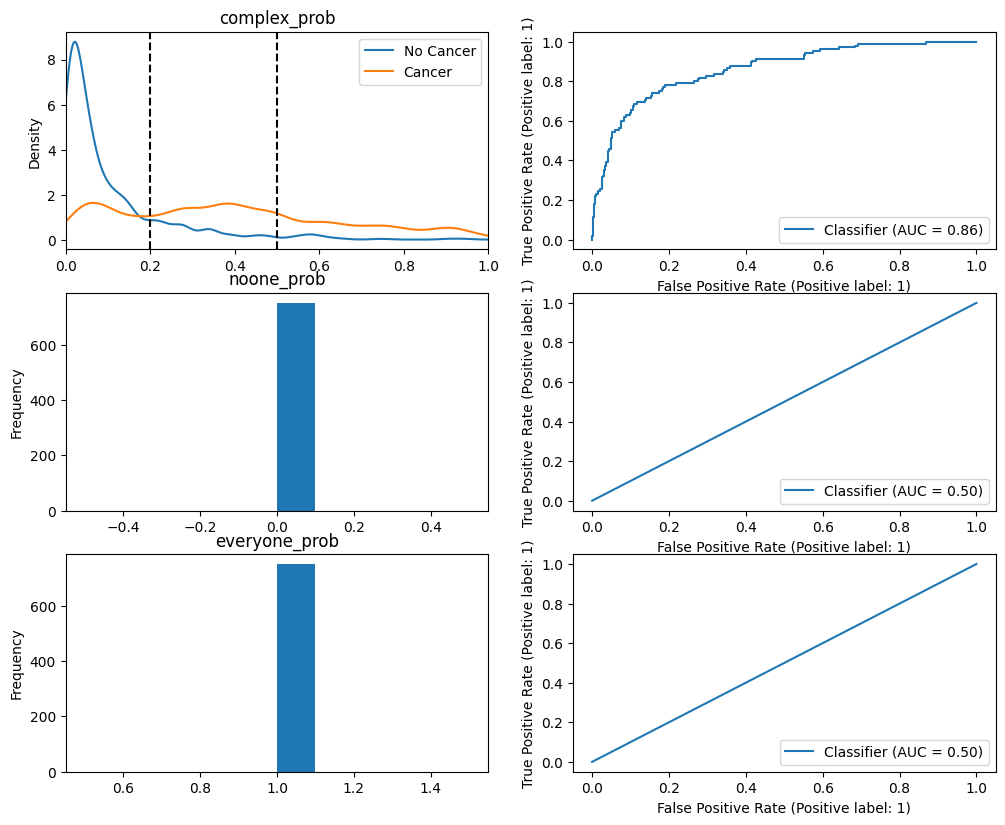

In [19]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(12,13))
base_subplot = 420

for i, col in enumerate(['complex_prob', 'noone_prob', 'everyone_prob']):
    roc_pos_offset = (2*(i + 1))
    plt.subplot(base_subplot + roc_pos_offset - 1)
    if col == 'complex_prob':
        prob_density_plot(df_cancer_dx, col, 'cancer', title=col)
    elif col == 'famhistory_prob':
        df_cancer_dx.groupby('cancer')[col].plot.hist(legend=True, xlim=(0,1), title=col)
    else:
        df_cancer_dx[col].plot(kind='hist', title=col)

    ax = plt.subplot(base_subplot + roc_pos_offset)
    RocCurveDisplay.from_predictions(y_true = df_cancer_dx['cancer'], y_pred = df_cancer_dx[col], ax=ax)

The plots also shows a so called AUC score, this is the area under the ROC curve. So the AUC curve says something about the performance of the model over the whole range of possible probability tresholds. This does mean that we do not get a performance of the model for a given decision threshold, but over the whole range of thresholds. This includes area with very bad sensitivity and specificity values, which is a common ciriticism of the AUC score as those areas would not be of interest to a competent researcher. 

The lowest value for the AUC is 0.5, which means that the classifier is no better than randomly guessing which patient needs a biopsy or not. Important to note in the figure:

- The ROC curves for the 'biopsy-no-one' and 'biopsy-everyone' show a flat line and an AUC of 0.5. For example for 'biopsy-everyone', all probabilites for all patients are 1. So the TPR for any probability threshold is 1 as all cancer patients are given a biopsy, but the FPR is also 1 as every non-cancer patient also are given a biopsy. The AUC is 0.5, so the 'biopsy-everyone' is no better then randomly choosing whom to biopsy. 
- The ROC curve for the complex model is a lot better, showing that model to be significantly better than randomly assigning biopsies. 

The AUC score provides a metric that is, in my opinion, much more in line with the medical intuition that biopsying no one is significantly worse than choosing whom to biopsy or not. Based on just the accuracy this was not the case. 

So the AUC is a much better metric that is not sensitive to unbalanced data, and this makes it very suitable for evaluating medical models. But there is still one problem: for the AUC an TP and an FP are equally impactful to the patient. But that does not feel correct: missing a cancer patient and having them die is obviously less impactful then an unecessary biopsy. We will look at a metric which does exactly that: the net benefit metric from decision curve analysis. 

# An ever better metric: net benefit
Decision curve analysis introduces a new metric called the net benefit. It frames the performance of the model as a cost-benefit analysis. The net benefit nicely builds up from our previous two metrics. Let's start with accuracy. 

### Accuracy cost-benefit
For accuracy, the costs are the times we make the wrong prediction (FN+FP), and the benefits are the correct predictions (TP+TN). Notice here that the accuracy only really looks at the benefits, and ignores the costs. And as we saw, by looking at the fraction of benefit versus the entire dataset, we end up being very vulnebrable to unbalanced datasets. 

### ROC cost-benefit
For the ROC curve, the costs are respresented by the FPR (unecessary biopsies) and the benefits by the TPR (accurate cancer prediction). Both are relative to the their respective number of patients in the dataset, which ensures that it is not susceptible to an unbalanced dataset. 

### Balancing unecessary biopsies and detecting cancer
The net benefit has a similar approach to the benefits and costs as the ROC. Given a decision threshold $\theta$, the net benefit is defined as:

$$NB_{\theta} = TPR_{\theta} \times \frac{n_{cancer}}{n} - FPR_{\theta} \times \frac{n_{non-cancer}}{n} \times \frac{\theta}{1-\theta}$$

where:

- $TPR_{\theta} \times \frac{n_{cancer}}{n}$ is the benefit of the comparison, in this case the fraction of cancer patients in the data that get a biopsy they need.
- $FPR_{\theta} \times \frac{n_{non-cancer}}{n}$ is the cost of the comparison, in this case the fraction of healthy people in the data getting an uneccesary biopsy.
- $\theta$ the decision threshold: how much risk of cancer would warrant a biopsy? Setting this to 0.1 means that when the probability is 10%, we order a biopsy to check. 
- $\frac{\theta}{1-\theta}$ specificies how much more important we judge an unecessary biopsy to be, which is linked to the decision threshold. For $\theta = 0.1$, this would lead to $\frac{1}{9}$ meaning we would accept 9 unnecessary biopsies for each detected cancer patient. 

Net benefit shows two advantages here:

- It incorporates the amount of healthy and sick patients into the benefit calculation, in contrast to AUC. 
- It allows varying risk acceptance per type of error: in this case most likely that we think undetected cancer (FN) is more impactful than an unnecessary biopsy (FP). 

This means that net benefit has a much more straightforward clinical interpretation. 

### Plotting net benefit: the decision curve
We obtain the titular decision curve by plotting $\theta$ versus the net benefit. We do this using the `dcurves` package, where we choose a number of settings wisely based on [this article](https://www.fharrell.com/post/edca/). We limit $\theta$ to a maximum of 0.36, no doctor would omit a biopsy when the chance of cancer is higher than 36%. We limit the lower range of net benefit to -0.05, net benefits lower than that will almost never ben clinically interesting. 

Use `dcurves`, the decision curve looks like this:

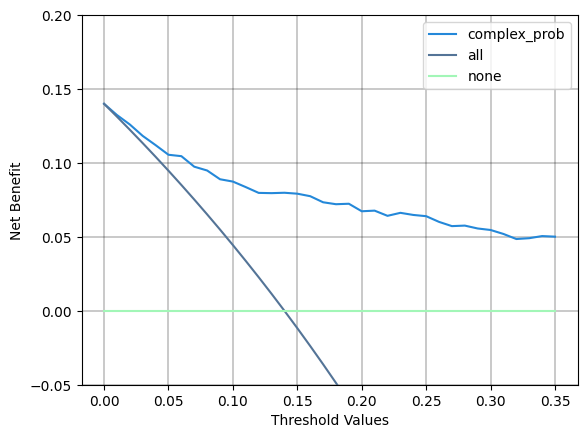

In [27]:
from dcurves import dca, plot_graphs

dca_multi_df = \
    dca(data=df_cancer_dx,
        outcome='cancer',
        modelnames=['complex_prob'],
        thresholds=np.arange(0,0.36,0.01))

plot_graphs(plot_df=dca_multi_df,
    y_limits=[-0.05, 0.2],
    graph_type='net_benefit')


Important in this graph:

- The biopsy-no-one option (`none`) always shows a net benefit of 0: you never make a mistake, but you also never detect a cancer patient. No cost, no benefit. 
- The biopsy-everyone option (`all`) shows good net benefit for lower values of $\theta$. This makes sense, as lower $\theta$ values emphasize catching cancer patients. In this range, biopsy-everyone is a better option than biopsy-no-one. Note that this particular curve starts at 0.14, which is exactly the fraction of people in the dataset with cancer. And the everyone and no one lines cross at $\theta$ equals 0.14, again the prevalence of cancer in the dataset. 
- Choosing who to biopsy based on our model almost always shows higher net benefit, and this represents the option with the clear clinical benefit. Only for really low $\theta$ values the biopsy-everyone option becomes viable, but that would mean a lot of unnecessary biopsies. 
- Plotting $\theta$ versus net benefit for all these options shows a more subtle performance distribution. In terms of AUC, the biopsy-no-one and everyone options where completely useless compared to the model. Now we see that the story is a bit more subtle, in a very extreme case one might even prefer the everyone option. 

This decision curve can be used in discussions with medical professionals: how much risk are we willing to take? At what percentage risk of cancer do we order a biopsy? This makes the statistical discussion nicely integrated into medical practice. 

# Conclusion
Looking at our three potential metrics, net benefit is clearly the best option in a medical setting. It does not have the sensitivity to unbalanced data, and it nicely extends on the strengths of ROC curves and the AUC score. 

# Acknowledgements
*TODO*

# Background information

- https://www.fharrell.com/post/edca/
- https://mskcc-epi-bio.github.io/decisioncurveanalysis/index.html
- https://mskcc-epi-bio.github.io/decisioncurveanalysis/literature.html
    - [Original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2577036/)
